# Config

In [1]:
import os
from tools.utils import *

In [2]:
# import conversion tools
from tools.conv_tools import *
from tools import conv_tools
ctools = get_funs_from_module(conv_tools)
#ctools.keys()

In [3]:
from tools import eval_tools
etools = get_funs_from_module(eval_tools)
#etools.keys()

# Load and Rearrange Files

In [4]:
from tools.utils import *
from tqdm.notebook import tqdm

In [5]:
data_path = os.path.join('data')

input_dir_path = os.path.join(data_path, 'docs_for_eval')

selected_conv_tools = ['PyPDF4_ocr',    # names of the tools for conversion
                    'extract_text',
                    'pdfminer_ocr',
                    'pdfreader_ocr',
                    'pytesseract_ocr',
                    'tika_ocr',  
                    ]
selected_scores = ['spellcheck_score',  # names of the scores for tool evaluation
                    ]
score_data_dirpath = 'evaluation_results'
score_data_filepath = os.path.join(score_data_dirpath,'scores')

doc_paths = [os.path.join(input_dir_path, filepath) for filepath in os.listdir(input_dir_path) if os.path.isfile(os.path.join(input_dir_path, filepath))]


In [6]:
%%capture
# if there are any imgs, convert them to pdf
not_pdf_filepaths = list_ext(input_dir_path,    # files to be converted to pdf
                            exts=['pdf'],
                            invert=True)

for not_pdf_filepath in not_pdf_filepaths:
    ctools['img2pdf']([not_pdf_filepath])

pdf_filepaths = list_ext(input_dir_path,        # all pdf files
                        exts=['pdf'],
                        invert=False)

In [7]:
# rearrange folder structure
for pdf_filepath in pdf_filepaths:
    mv_to_custom_dir(pdf_filepath)
for not_pdf_filepath in not_pdf_filepaths:
    os.remove(not_pdf_filepath)

In [8]:
dir_paths = get_child_dir_paths(input_dir_path)

# compile metadata for each file
for dir_path in tqdm(dir_paths, desc='dir_paths'):
    metadata = get_metadata(dir_path,
                            storage_opts={'lang_codes':True, 'emb_txt':True},
                            overwrite_opts={'lang_codes':False, 'emb_txt':False},
                            )

    store_data(storage='meta',
                data=metadata,
                dir_path=dir_path,
                name='metadata',
                )

dir_paths:   0%|          | 0/25 [00:00<?, ?it/s]

# Conversion

In [9]:
from tools.conv_tools import *
import sys
from tqdm.notebook import tqdm

In [10]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

for dir_path in tqdm(dir_paths, desc='dir_paths: '):
    ocr_txt = get_txt(dir_path,
                    tool_names=selected_conv_tools,
                    tools=ctools,
                    storage_opts={'ocr_txt':True, 'ocr_txt_trans':False},
                    overwrite_opts={'ocr_txt':False, 'ocr_txt_trans':False},
                    )

    store_data(storage='dir',
                data=ocr_txt,
                dir_path=dir_path,
                name='ocr_extraction')

dir_paths:   0%|          | 0/25 [00:00<?, ?it/s]

# Evaluation

In [11]:
from tools.eval_tools import eval_tools_scores
from tqdm.notebook import tqdm

In [12]:
scores_results = eval_tools_scores(db_dir_path=input_dir_path,
                                conv_tool_names=selected_conv_tools, # tools to be evaluated
                                score_names=selected_scores,
                                scoring_funs=etools,
                                store_path=score_data_dirpath,
                                max_words_per_doc=100)
scores_results

max_words_per_doc: 100


  0%|          | 0/25 [00:00<?, ?it/s]

{'spellcheck_score': {'PyPDF4_ocr': 596,
  'extract_text': 1444,
  'pdfminer_ocr': 1439,
  'pdfreader_ocr': 1567,
  'pytesseract_ocr': 1387,
  'tika_ocr': 1436}}

# Visualisation

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
with open(score_data_filepath+'.json', 'r') as f:
    score_results = json.load(f)

In [15]:
score_name = selected_scores[0]
data = score_results[score_name]

Text(0, 0.5, 'spellcheck_score')

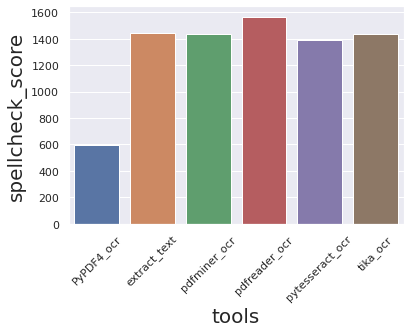

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=45)
p = sns.barplot(x=list(data.keys()), y=list(data.values()))
p.set_xlabel('tools', fontsize = 20)
p.set_ylabel(score_name, fontsize = 20)

In [17]:
p.figure.savefig(score_data_filepath+'.png')